In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob
from COVID_study_processing import MTBLSDataset

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\cw2019\.conda\envs\py10\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Combining multiple assay sheets

In [2]:
# MTBLS2224
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = {'Case': 'Positive', 'Control': 'Negative'},
    outliers='FU22')

['Studies/MTBLS2224\\m_MTBLS2224_GC-MS_positive__metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS2224\\m_MTBLS2224_LC-MS_negative_reverse-phase_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS2224\\m_MTBLS2224_LC-MS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv']
(2770, 101)
  Sample Name Factor Value[COVID Infection]
0        QC-3                           NaN
1        QC-4                           NaN
2        QC-5                           NaN
3        QC-6                           NaN
4        QC-7                           NaN
(2770, 102)
(80, 2770)
Missingness: 0.00%
Number of differentially abundant metabolites: 811


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\scipy\stats\_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


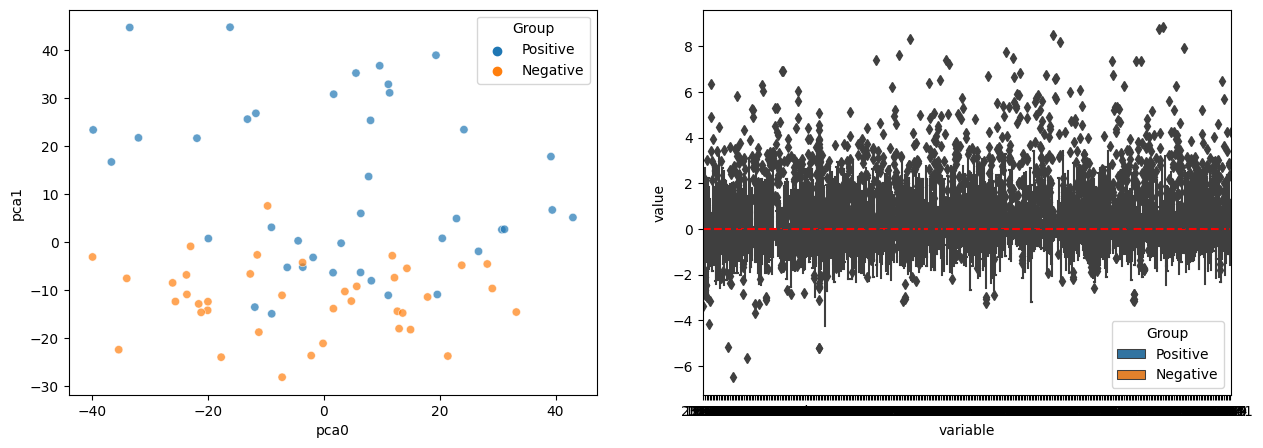

In [135]:
s2224.plot_qc()

In [140]:
s2224.pval_df

,P-value,Stat,Direction,FDR_P-value
27389,0.609474,-0.512922,Down,0.763911
15862,0.000007,-4.832059,Down,0.000085
19475,0.000018,-4.581296,Down,0.000178
16830,0.000005,-4.904714,Down,0.000067
30763,0.081223,1.766809,Up,0.183814
...,...,...,...,...
88433,0.349492,0.941305,Up,0.526699
23051,0.959959,-0.050369,Down,0.976528
174771,0.056702,1.934686,Up,0.139613
188345,0.532151,-0.627557,Down,0.700752


In [56]:
s2224.pca['pca0'].sort_values()

AS7     -36.228322
FU38    -33.771765
FU7     -31.848399
AS20    -31.283913
AS31    -29.877204
           ...    
FU10     28.113247
AS3      30.898847
AS19     31.156003
AS21     35.080255
FU22    104.947606
Name: pca0, Length: 80, dtype: float64

In [6]:
s2224.raw_data['mass_to_charge'].nunique()

2580

In [138]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob
import sspa


class MTBLSDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, md_group, md_filter, maf_sheet=0, identifier='database_identifier', outliers=None, pathway_level=False):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None
        self.maf_sheet = maf_sheet
        self.identifier = identifier
        self.outliers = outliers
        self.pathway_data = None
        self.pathway_level = pathway_level
        self.pathway_coverage = None

        self.read_data(file_path)
        self.preprocess_data()
        self.get_pathway_data()
        self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolights format data
        """
        # read in the maf files
        files = glob.glob(file_path + '/*_maf.tsv')
        print(files)
        # for now only use one maf file

        if len(files) > 1:
            if self.maf_sheet:
                filt_files = [files[i] for i in self.maf_sheet]
                data = pd.concat([pd.read_csv(f, sep='\t') for f in filt_files], join='inner')
            else:
                # read all files in 
                data = pd.concat([pd.read_csv(f, sep='\t') for f in files], join='inner')
        else:
            data = pd.read_csv(files[0], sep='\t')

        self.raw_data = data
        print(data.shape)

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t', encoding='unicode_escape')

        self.metadata = metadata
        self.metadata['Sample Name'] = self.metadata['Sample Name'].astype(str)
        print(metadata[['Sample Name', self.md_group]].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()

        # repalce decimal in mz ratios
        try:
            data_filt['mass_to_charge'] = data_filt['mass_to_charge'].astype('str').apply(lambda x: re.sub(r'\.', '_', x))
        except KeyError:
            pass

        self.all_ids = data_filt.iloc[:, ~data_filt.columns.isin(self.metadata['Sample Name'].tolist())]

        # make a new identifier colum from chebi and metabolite_identification, prioritise chebi
        data_filt['Identifier'] = data_filt['database_identifier'].fillna(data_filt['metabolite_identification'])
        data_filt = data_filt[data_filt['Identifier'].notna()]
        data_filt.index = data_filt['Identifier']

        # # set chebi as index
        # data_filt = data_filt[data_filt[self.identifier].notna()]
        # data_filt.index = data_filt[self.identifier]
        print(data_filt.shape)
        # keep only abundance data filtering on samples
        # store alternative identifiers in a dict
        samples = self.metadata['Sample Name'].tolist()
        ids = data_filt.iloc[:, ~data_filt.columns.isin(samples)]
        self.id_dict = ids.to_dict()
        data_filt = data_filt.iloc[:, data_filt.columns.isin(samples)]

        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T
        print(data_filt.shape)

        # There weill be QC samples so better filter on metadata at this point
        md_dict = dict(zip(self.metadata['Sample Name'], self.metadata[self.md_group]))
        # add metadata column
        data_filt['Group'] = data_filt.index.map(md_dict)

    #     # filter on metadata
        data_filt = data_filt[data_filt['Group'].isin(self.md_filter.values())]
        data_filt = data_filt.drop(columns=['Group'])

        # drop outliers
        if self.outliers:
            data_filt = data_filt.drop(self.outliers)

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete rows and columns where all values are 0 
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)
        self.processed_data = data_scaled

        return data_scaled
    
    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='Reactome_Homo_sapiens_pathways_ChEBI_R88.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        # remove CHEBI: from column names
        data = self.processed_data
        data.columns = data.columns.str.removeprefix("CHEBI:")

        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
    
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()

    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]

    # def get_class_info(self, hmdbs=None):

    #     if hmdbs == None:
    #         hmdbs = self.compound_mappers['HMDB'].tolist()
    #     hmdb_ids = ['hmdb:' + str(hmdb) for hmdb in hmdbs if not pd.isna(hmdb)]
    #     print(hmdb_ids)
    #     api_url = "https://rampdb.nih.gov/api/chemical-classes"
    #     request_body = {
    #     "metabolites": hmdb_ids
    #     }
    #     response = requests.post(api_url, json=request_body, verify=False)
    #     resp_json = response.json()['data']
    #     resp_df = pd.DataFrame.from_dict(resp_json)
    #     return resp_df
    




In [8]:
s2014 = MTBLSDataset(
    file_path = 'Studies/MTBLS2014', 
    id = 'MTBLS2014', 
    node_name = 'MTBLS2014', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Control':'Healthy', 'Case':'Patient (+) SARS-CoV-2'},
    outliers=['12JUN2020_AAA_COV_PL_068'])

['Studies/MTBLS2014\\m_MTBLS2014_LC-MS_positive_reverse-phase_metabolite_profiling_v4_maf.tsv']
(34, 70)
                Sample Name   Factor Value[Disease]
0  03JUN2020_COV_AAA_PL_021                 Healthy
1  03JUN2020_COV_AAA_PL_024                 Healthy
2  03JUN2020_COV_AAA_PL_029  Patient (+) SARS-CoV-2
3  03JUN2020_COV_AAA_PL_032  Patient (+) SARS-CoV-2
4  03JUN2020_COV_AAA_PL_035  Patient (+) SARS-CoV-2
(34, 71)
(49, 34)
Missingness: 0.00%
Number of differentially abundant metabolites: 11


In [46]:
s2014.processed_data.shape

(49, 35)

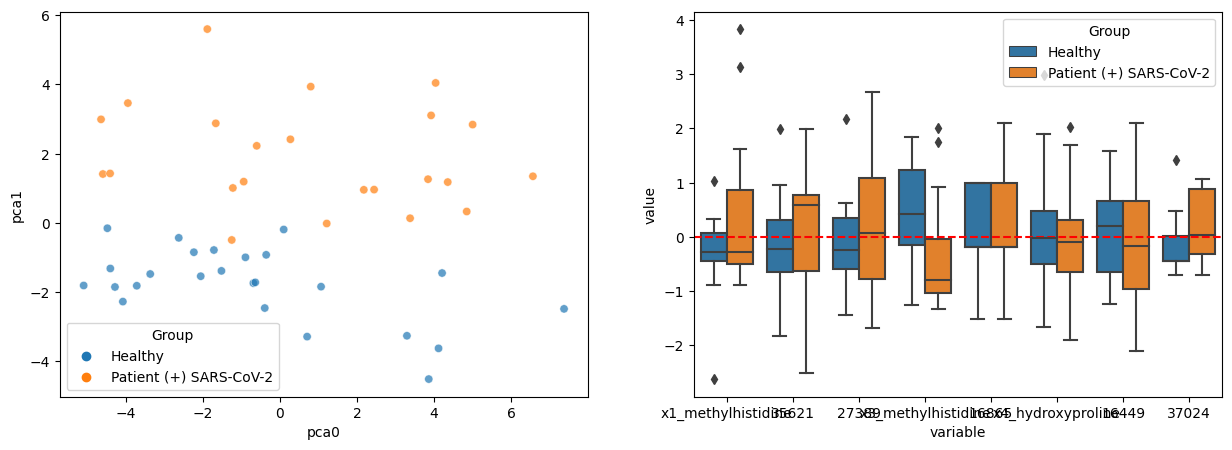

In [60]:
s2014.plot_qc()

In [52]:
s2014.pca['pca0'].sort_values()

12JUN2020_AAA_COV_PL_085    -7.335005
12JUN2020_AAA_COV_PL_090    -6.403469
12JUN2020_AAA_COV_PL_033    -4.771409
20200622_AAA_COV_PL_042     -4.634622
12JUN2020_AAA_COV_PL_086    -4.380629
12JUN2020_AAA_COV_PL_083    -4.341390
12JUN2020_AAA_COV_PL_059    -4.306598
20200622_AAA_COV_PL_047     -4.024106
12JUN2020_AAA_COV_PL_072    -3.832505
12JUN2020_AAA_COV_PL_034    -3.783785
12JUN2020_AAA_COV_PL_047    -3.776988
20200622_AAA_COV_PL_035     -3.515052
12JUN2020_AAA_COV_PL_031    -3.294782
20200622_AAA_COV_PL_041     -2.137319
20200622_AAA_COV_PL_040     -2.101057
20200622_AAA_COV_PL_039     -1.263177
20200622_AAA_COV_PL_034     -1.221602
03JUN2020_COV_AAA_PL_052    -1.085350
12JUN2020_AAA_COV_PL_036    -0.718991
12JUN2020_AAA_COV_PL_058    -0.415245
12JUN2020_AAA_COV_PL_078    -0.406527
12JUN2020_AAA_COV_PL_084    -0.060416
12JUN2020_AAA_COV_PL_088     0.000617
03JUN2020_COV_AAA_PL_094     0.317925
03JUN2020_COV_AAA_PL_081     0.318929
20200622_AAA_COV_PL_037      0.414705
12JUN2020_AA

In [133]:
# metadata does not match maf sheet - manually remove dates in metadata file
# s2291_md = pd.read_csv('Studies/MTBLS2291/s_MTBLS2291.txt', sep='\t')
# s2291_md['Sample Name'] = s2291_md['Sample Name'].str[9:]
# s2291_md.to_csv('Studies/MTBLS2291/s_MTBLS2291.txt', sep='\t', index=False)

In [10]:
s2014.raw_data['mass_to_charge'].nunique()

27

In [12]:
s2291 = MTBLSDataset(
    file_path = 'Studies/MTBLS2291', 
    id = 'MTBLS2291', 
    node_name = 'MTBLS2291', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Negative COVID-19', 'Case': 'Severe COVID-19'},
    outliers=['CovidNeg_P251_P_3',
 'CovidNeg_P251_P_4',
 'CovidNeg_P252_P_3',
 'CovidNeg_P252_P_4',
 'CovidNeg_P253_P_3',
 'CovidNeg_P253_P_4',
 'CovidNeg_P254_P_3',
 'CovidNeg_P254_P_4',
 'CovidNeg_P257_P_3',
 'CovidNeg_P257_P_4',
 'CovidNeg_P258_P_3',
 'CovidNeg_P258_P_4',
 'CovidNeg_P259_P_3',
 'CovidNeg_P259_P_4',
 'CovidNeg_P260_P_3',
 'CovidNeg_P260_P_4',
 'CovidNeg_P261_P_3',
 'CovidNeg_P261_P_4',
 'CovidNeg_P262_P_3',
 'CovidNeg_P262_P_4',
 'CovidNeg_P263_P_3',
 'CovidNeg_P263_P_4',
 'CovidNeg_P264_P_3',
 'CovidNeg_P264_P_4',
 'CovidNeg_P265_P_3',
 'CovidNeg_P265_P_4',
 'CovidNeg_P266_P_3',
 'CovidNeg_P266_P_4',
 'CovidNeg_P267_P_3',
 'CovidNeg_P267_P_4',
 'CovidNeg_P268_P_3',
 'CovidNeg_P268_P_4',
 'CovidNeg_P269_P_3',
 'CovidNeg_P269_P_4',
 'CovidNeg_P270_P_3',
 'CovidNeg_P270_P_4',
 'CovidNeg_P271_P_3',
 'CovidNeg_P271_P_4',
 'CovidSevere_P273_P_3',
 'CovidSevere_P273_P_4',
 'CovidSevere_P272_P_3',
 'CovidSevere_P272_P_4',
 'CovidSevere_P283_P_3',
 'CovidSevere_P283_P_4',
 'CovidSevere_P284_P_3',
 'CovidSevere_P284_P_4',
 'CovidSevere_P285_P_3',
 'CovidSevere_P285_P_4'])

['Studies/MTBLS2291\\m_MTBLS2291_LC-MS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv']
(1900, 318)
          Sample Name Factor Value[Disease severity]
0  CovidMild_P274_P_2            Non-severe COVID-19
1  CovidMild_P274_P_3            Non-severe COVID-19
2  CovidMild_P274_P_4            Non-severe COVID-19
3  CovidMild_P275_P_2            Non-severe COVID-19
4  CovidMild_P275_P_3            Non-severe COVID-19
(1900, 319)
(146, 1900)
Missingness: 17.93%
Number of differentially abundant metabolites: 72


In [49]:
s2291.processed_data.shape

(125, 191)

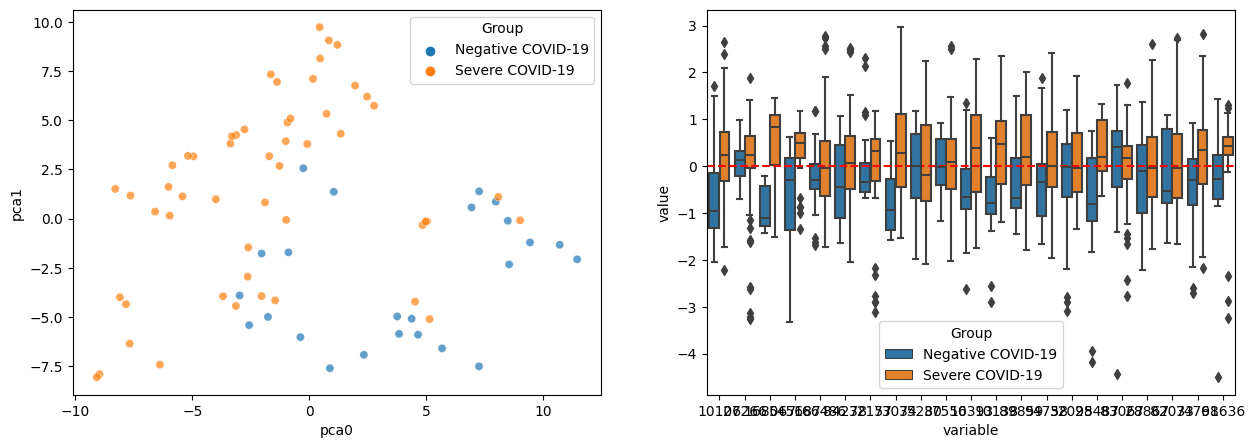

In [72]:
s2291.plot_qc()

In [66]:
s2291_pca = s2291.pca['pca0']

In [69]:
s2291_pca[s2291_pca > 1].index.tolist()

['CovidNeg_P251_P_3',
 'CovidNeg_P251_P_4',
 'CovidNeg_P252_P_3',
 'CovidNeg_P252_P_4',
 'CovidNeg_P253_P_3',
 'CovidNeg_P253_P_4',
 'CovidNeg_P254_P_3',
 'CovidNeg_P254_P_4',
 'CovidNeg_P257_P_3',
 'CovidNeg_P257_P_4',
 'CovidNeg_P258_P_3',
 'CovidNeg_P258_P_4',
 'CovidNeg_P259_P_3',
 'CovidNeg_P259_P_4',
 'CovidNeg_P260_P_3',
 'CovidNeg_P260_P_4',
 'CovidNeg_P261_P_3',
 'CovidNeg_P261_P_4',
 'CovidNeg_P262_P_3',
 'CovidNeg_P262_P_4',
 'CovidNeg_P263_P_3',
 'CovidNeg_P263_P_4',
 'CovidNeg_P264_P_3',
 'CovidNeg_P264_P_4',
 'CovidNeg_P265_P_3',
 'CovidNeg_P265_P_4',
 'CovidNeg_P266_P_3',
 'CovidNeg_P266_P_4',
 'CovidNeg_P267_P_3',
 'CovidNeg_P267_P_4',
 'CovidNeg_P268_P_3',
 'CovidNeg_P268_P_4',
 'CovidNeg_P269_P_3',
 'CovidNeg_P269_P_4',
 'CovidNeg_P270_P_3',
 'CovidNeg_P270_P_4',
 'CovidNeg_P271_P_3',
 'CovidNeg_P271_P_4',
 'CovidSevere_P273_P_3',
 'CovidSevere_P273_P_4',
 'CovidSevere_P272_P_3',
 'CovidSevere_P272_P_4',
 'CovidSevere_P283_P_3',
 'CovidSevere_P283_P_4',
 'CovidSevere_

In [138]:
# metadata does not match maf sheet - manually remove dates in metadata file
# s2349_md = pd.read_csv('Studies/MTBLS2349/s_MTBLS2349.txt', sep='\t')
# s2349_md['Sample Name'] = s2349_md['Sample Name'].str[9:]
# s2349_md.to_csv('Studies/MTBLS2349/s_MTBLS2349.txt', sep='\t', index=False)

In [16]:
s2291.raw_data['mass_to_charge']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1895   NaN
1896   NaN
1897   NaN
1898   NaN
1899   NaN
Name: mass_to_charge, Length: 1900, dtype: float64

In [73]:
s2349 = MTBLSDataset(
    file_path = 'Studies/MTBLS2349', 
    id = 'MTBLS2349', 
    node_name = 'MTBLS2349', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = ['Negative COVID-19', 'Severe COVID-19'])

1
            Sample Name Factor Value[Disease severity]
0  CovidSwabPos_242_P_4            Non-severe COVID-19
1  CovidSwabPos_242_P_2            Non-severe COVID-19
2  CovidSwabPos_231_P_4            Non-severe COVID-19
3  CovidSwabPos_231_P_3            Non-severe COVID-19
4  CovidSwabPos_233_P_2            Non-severe COVID-19
Missingness: nan%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_32480\1303842770.py:127: RuntimeWarning: invalid value encountered in scalar divide
  missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100


ValueError: at least one array or dtype is required

In [140]:
s2349.processed_data.shape

(0, 44)

In [18]:
s6844 = MTBLSDataset(
    file_path = 'Studies/MTBLS6844', 
    id = 'MTBLS6844', 
    node_name = 'MTBLS6844', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'Severe', 'Control':'Mild'},
    outliers='SEVERE6')

['Studies/MTBLS6844\\m_MTBLS6844_FIA-MS_positive__metabolite_profiling_v2_maf.tsv']
(483, 75)
  Sample Name Factor Value[Disease]
0       Blank                   NaN
1         PBS                   NaN
2  Calibrants                   NaN
3          QC                   NaN
4       MILD1                  Mild
(483, 76)
(53, 483)
Missingness: 0.00%
Number of differentially abundant metabolites: 0


In [75]:
s6844.processed_data.shape

(37, 484)

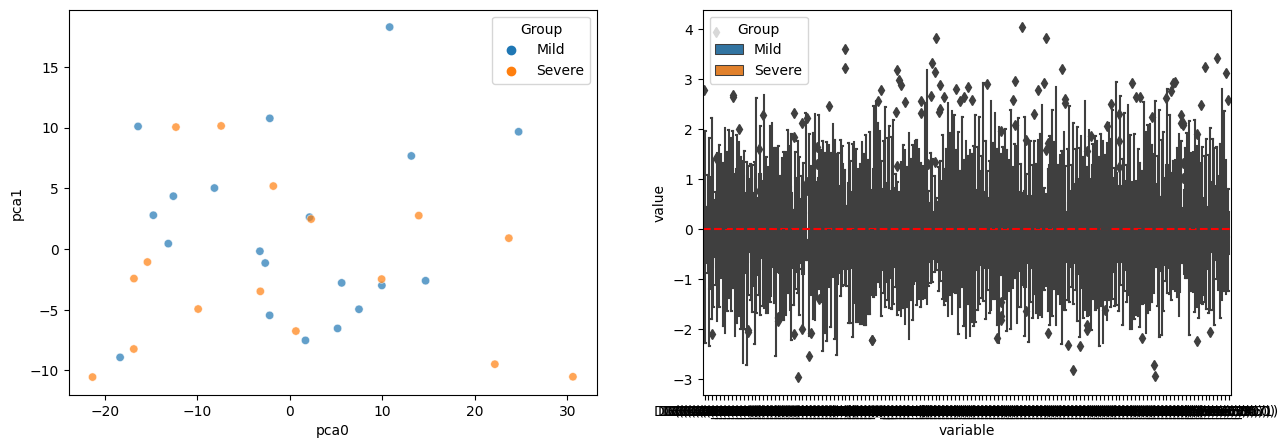

In [82]:
s6844.plot_qc()

In [80]:
s6844.pca.sort_values(by='pca1')

,pca0,pca1
MILD5,10.552224,-13.783381
MILD13,13.499910,-10.689060
MILD10,-15.834474,-9.984098
SEVERE12,-6.811680,-8.660625
SEVERE10,-11.621684,-8.553704
MILD6,-2.189452,-8.020486
MILD20,23.993185,-6.400782
MILD4,-7.902302,-6.022201
SEVERE17,13.650277,-4.752176
MILD18,-14.339420,-4.432409


In [20]:
s6844.raw_data['mass_to_charge']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
478   NaN
479   NaN
480   NaN
481   NaN
482   NaN
Name: mass_to_charge, Length: 483, dtype: float64

In [21]:
s718 = MTBLSDataset(
    file_path = 'Studies/MTBLS718', 
    id = 'MTBLS718', 
    node_name = 'MTBLS718', 
    md_group = 'Factor Value[Condition]', 
    md_filter = {'Case':'COVID-19', 'Control':'Healthy Control'})

['Studies/MTBLS718\\m_MTBLS718_LC-MS_HPOS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS718\\m_MTBLS718_LC-MS_LNEG_negative_reverse-phase_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS718\\m_MTBLS718_LC-MS_LPOS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv']


d:\MARIANA2\HDN\MetHDN\MetDMN\COVID_study_processing.py:58: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([pd.read_csv(f, sep='\t') for f in files], join='inner')


(5545, 255)
  Sample Name Factor Value[Condition]
0     IP-0793      Pre-COVID-19 viral
1     IP-3398                COVID-19
2     IP-3400                COVID-19
3      MP-006                COVID-19
4     IP-0929          Unwell Control
(5545, 256)
(234, 5545)
Missingness: 0.00%
Number of differentially abundant metabolites: 1732


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\scipy\stats\_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [84]:
s718.processed_data.shape

(117, 4349)

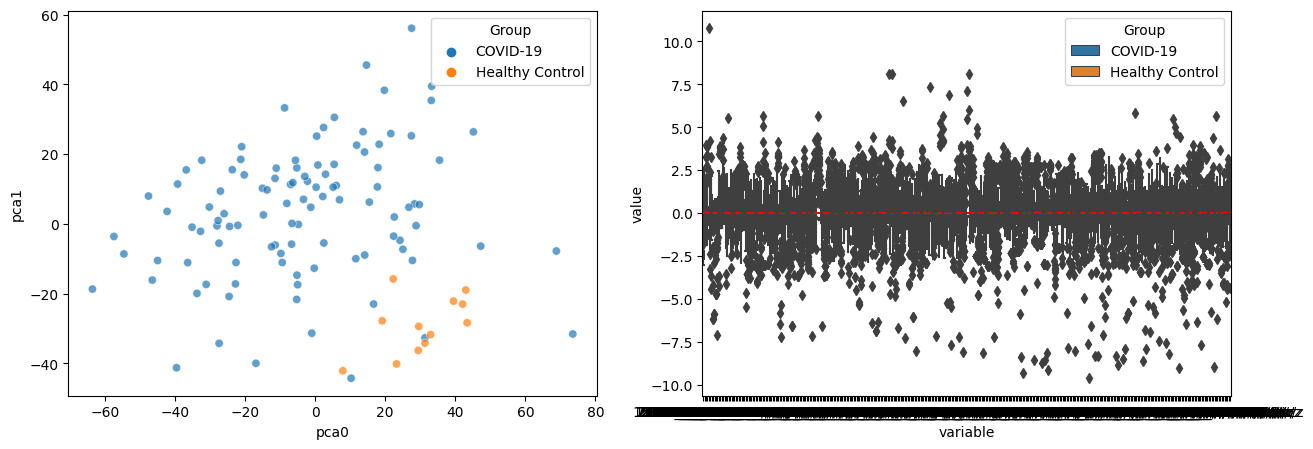

In [85]:
s718.plot_qc()

In [24]:
s718.raw_data['mass_to_charge'].nunique()


5545

In [26]:
s1866 = MTBLSDataset(
    file_path = 'Studies/MTBLS1866', 
    id = 'MTBLS1866', 
    node_name = 'MTBLS1866', 
    md_group = 'Factor Value[Medical case]', 
    md_filter = {'Control':'HEALTHY', 'Case':'COVID-19'},
    outliers='SA 8')

['Studies/MTBLS1866\\m_MTBLS1866_GCxGC-MS_positive__metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS1866\\m_MTBLS1866_LC-MS_negative_reverse-phase_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS1866\\m_MTBLS1866_LC-MS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv']
(824, 172)
  Sample Name Factor Value[Medical case]
0           1                   COVID-19
1          41                   COVID-19
2         101                   COVID-19
3          62                   COVID-19
4         104                   COVID-19
(824, 173)
(124, 824)
Missingness: 0.00%
Number of differentially abundant metabolites: 407


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\scipy\stats\_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


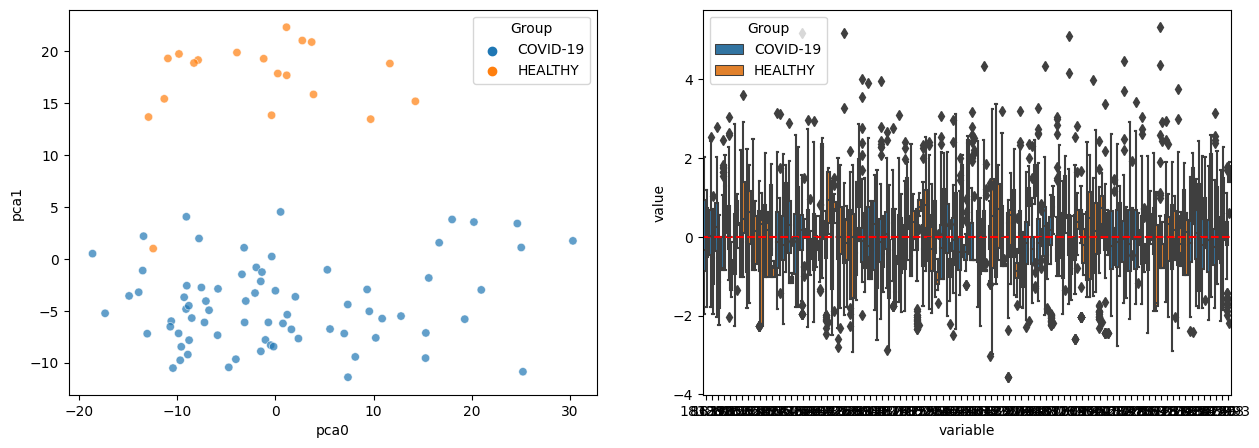

In [92]:
s1866.plot_qc()

In [90]:
s1866.pca['pca1'].sort_values()

4        -14.844169
101      -13.957526
48       -13.679545
106      -12.953470
POS 14   -11.974383
            ...    
EB        17.372691
MM        17.683958
SA 7      17.948045
SA 5      18.034817
SA 8      50.638618
Name: pca1, Length: 94, dtype: float64

In [29]:
s1866.raw_data['mass_to_charge'].nunique()

745

In [93]:
s2224 = MTBLSDataset(
    file_path = 'Studies/MTBLS2224', 
    id = 'MTBLS2224', 
    node_name = 'MTBLS2224', 
    md_group = 'Factor Value[COVID Infection]', 
    md_filter = ['Positive', 'Negative'])

3
  Sample Name Factor Value[COVID Infection]
0        QC-3                           NaN
1        QC-4                           NaN
2        QC-5                           NaN
3        QC-6                           NaN
4        QC-7                           NaN
Missingness: 0.00%


KeyboardInterrupt: 

In [241]:
s2224.processed_data.shape

(80, 377)

0


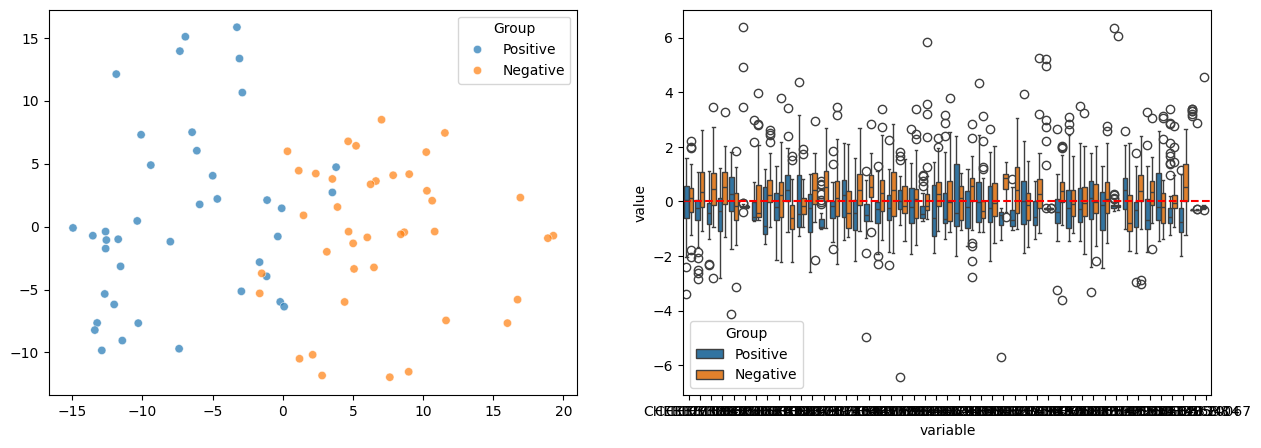

In [242]:
s2224.plot_qc()

In [30]:
s2336 = MTBLSDataset(
    file_path = 'Studies/MTBLS2336', 
    id = 'MTBLS2336', 
    node_name = 'MTBLS2336', 
    md_group = 'Factor Value[Disease]', 
    md_filter = {'Case':'COVID-19', 'Control': 'Healthy (control)'})

['Studies/MTBLS2336\\m_MTBLS2336_NMR_metabolite_profiling_v2_maf.tsv']
(22, 86)
     Sample Name Factor Value[Disease]
0  COVID_ANN_001              COVID-19
1  COVID_ANN_002              COVID-19
2  COVID_ANN_003              COVID-19
3  COVID_ANN_004              COVID-19
4  COVID_ANN_005              COVID-19
(22, 87)
(68, 22)
Missingness: 0.00%
Number of differentially abundant metabolites: 13


In [238]:
s2336.processed_data.shape

(68, 21)

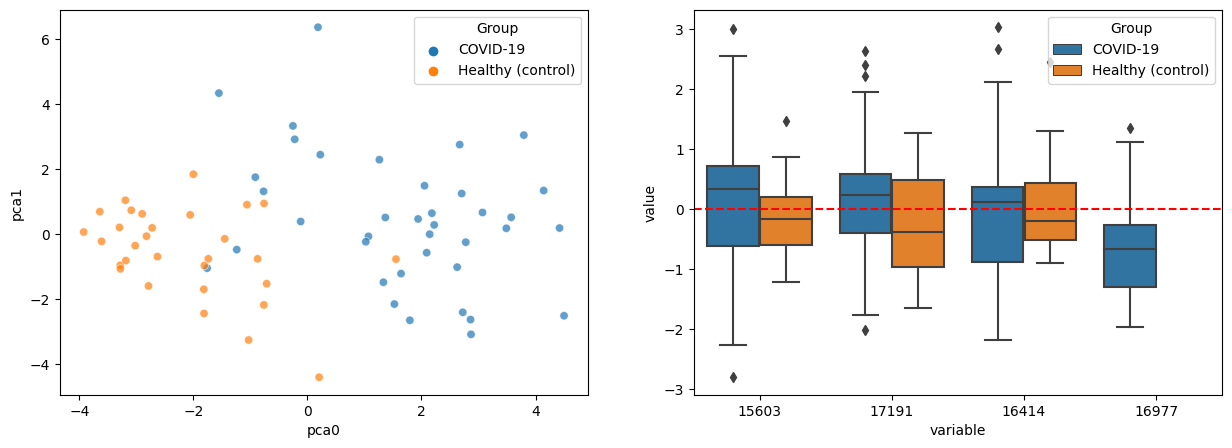

In [95]:
s2336.plot_qc()

In [35]:
s2336.raw_data['metabolite_identification']

0                  L-Leucine
1               L-Isoleucine
2                   L-Valine
3                  L-Alanine
4                    Acetate
5     N-Acetyl Glycoproteins
6          3-hydroxybutyrate
7                L-Glutamate
8                   Pyruvate
9                L-Glutamine
10                   Citrate
11                   Glycine
12                  Creatine
13                Creatinine
14                   Lactate
15                 D-mannose
16                 D-Glucose
17                L-Tyrosine
18               L-Histidine
19                   unknown
20           L-Phenylalanine
21                   Formate
Name: metabolite_identification, dtype: object

In [36]:
s2542 = MTBLSDataset(
    file_path = 'Studies/MTBLS2542', 
    id = 'MTBLS2542', 
    node_name = 'MTBLS2542', 
    md_group = 'Factor Value[Disease severity]', 
    md_filter = {'Control':'Mild', 'Case':'Death'},
    maf_sheet=[3])

['Studies/MTBLS2542\\m_MTBLS2542_Lipid_LC-MS_negative_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_Lipid_LC-MS_positive_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_Metabo_LC-MS_negative_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_Metabo_LC-MS_positive_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_NEG_Lipid_LC-MS_negative_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_NEG_Metabo_LC-MS_negative_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_POS_Lipid_LC-MS_negative_reverse-phase_v2_maf.tsv', 'Studies/MTBLS2542\\m_MTBLS2542_POS_Metabo_LC-MS_negative_reverse-phase_v2_maf.tsv']
(515, 180)
              Sample Name Factor Value[Disease severity]
0  20P02820001_BEHC18_NEG                           Mild
1  20P02820001_BEHC18_POS                           Mild
2  20P02820002_BEHC18_NEG                           Mild
3  20P02820002_BEHC18_POS                           Mild
4  20P02820006_BEHC18_NEG                  

In [127]:
s2542.processed_data.shape

(68, 516)

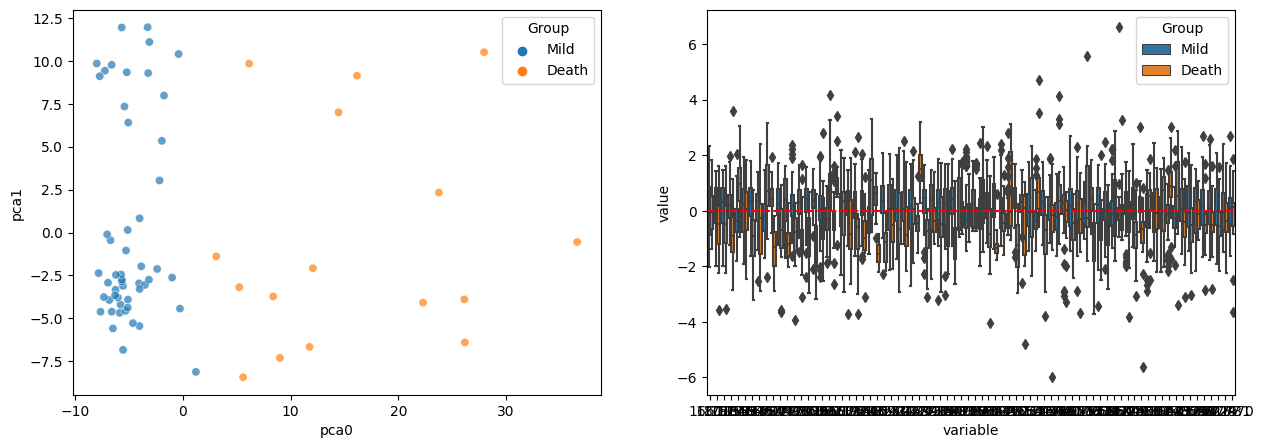

In [128]:
s2542.plot_qc()

In [39]:
s2542.raw_data['mass_to_charge'].nunique()

0

In [124]:
s1987 = MTBLSDataset(
    file_path = 'Studies/MTBLS1987', 
    id = 'MTBLS1987', 
    node_name = 'MTBLS1987', 
    md_group = 'Factor Value[Disease]', 
    md_filter = ['COVID-19', 'Healthy Control'])

['Studies/MTBLS1987\\m_MTBLS1987_LC-MS_negative_hilic_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS1987\\m_MTBLS1987_LC-MS_negative_reverse-phase_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS1987\\m_MTBLS1987_LC-MS_positive_hilic_metabolite_profiling_v2_maf.tsv', 'Studies/MTBLS1987\\m_MTBLS1987_LC-MS_positive_reverse-phase_metabolite_profiling_v2_maf.tsv']
(75, 21)
  Sample Name Factor Value[Disease]
0         QC1              COVID-19
1         QC2              COVID-19
2         QC3              COVID-19
3         QC4              COVID-19
4         QC5              COVID-19
(75, 22)
(0, 75)
Missingness: nan%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_32480\963949650.py:133: RuntimeWarning: invalid value encountered in scalar divide
  missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100


ValueError: at least one array or dtype is required

# How many m/z values match 

In [41]:
s718.raw_data['mass_to_charge']

0        248.064737
1        248.064776
2        264.038721
3        100.076943
4        114.067643
           ...     
2252    1647.221074
2253    1648.223682
2254    1668.201675
2255    1669.205200
2256    1670.207698
Name: mass_to_charge, Length: 5545, dtype: float64

In [42]:
s1866.raw_data['mass_to_charge']

0      165.07000
1      292.13000
2      136.11000
3      209.04000
4       57.06000
         ...    
472    711.56586
473    829.79938
474    376.39481
475    341.28061
476    738.64795
Name: mass_to_charge, Length: 824, dtype: float64

In [43]:
s2224.raw_data['mass_to_charge']

0       107.000000
1       174.000000
2       187.000000
3       171.000000
4       195.000000
           ...    
1236    790.573731
1237    447.346571
1238    310.053157
1239    314.029843
1240    503.258222
Name: mass_to_charge, Length: 2770, dtype: float64

In [46]:
set(s2224.raw_data['mass_to_charge'].tolist()).intersection(s718.raw_data['mass_to_charge'].tolist())

set()

In [47]:
set(s1866.raw_data['mass_to_charge'].tolist()).intersection(s718.raw_data['mass_to_charge'].tolist())

set()

In [48]:
set(s2224.raw_data['mass_to_charge'].tolist()).intersection(s1866.raw_data['mass_to_charge'].tolist())

{114.0, 130.0, 174.0, 180.0, 188.0, 202.0, 247.0, 280.0, 298.0, 441.0}

In [52]:
print(len(set(s2224.raw_data['mass_to_charge'].round(5).tolist()).intersection(s718.raw_data['mass_to_charge'].round(5).tolist())))
print(len(set(s1866.raw_data['mass_to_charge'].round(5).tolist()).intersection(s718.raw_data['mass_to_charge'].round(5).tolist())))
print(len(set(s2224.raw_data['mass_to_charge'].round(5).tolist()).intersection(s1866.raw_data['mass_to_charge'].round(5).tolist())))

1
2
10


In [51]:
print(len(set(s2224.raw_data['mass_to_charge'].round(2).tolist()).intersection(s718.raw_data['mass_to_charge'].round(2).tolist()).intersection(s1866.raw_data['mass_to_charge'].round(2).tolist())))

89


In [57]:
s718.raw_data['mass_to_charge'].round(2)

0        248.06
1        248.06
2        264.04
3        100.08
4        114.07
         ...   
2252    1647.22
2253    1648.22
2254    1668.20
2255    1669.21
2256    1670.21
Name: mass_to_charge, Length: 5545, dtype: float64